# Computer vision

En el presente trabajo se tratara un problema de clasificacion binaria, el cual consiste en determinar, por medio de redes neuronales artificiales, si una persona esta sonriendo o no en una imagen determinada.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
import tensorflow as tf

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

Using TensorFlow backend.


## Carga de datos

Comenzaremos definiendo las carpetas donde tenemos almacenados los datasets y las imagenes. El conjunto de datos como tal consta de multiples datasets con diferentes tipos de informacion sobre fotos de personas. Nosotros nos enfocaremos en  la variable Smiling, por lo cual extraeremos esa variable y eliminaremos todas las demas.

In [38]:
FOLDER_IMAGES = 'imagenes_tp3_cv/'

In [39]:
all_data = pd.read_csv('list_eval_partition.csv')

In [40]:
all_data_attributes = pd.read_csv('list_attr_celeba.csv')

Luego agregaremos nuestra variable de interes, Smiling, a nuestro dataset.

In [41]:
all_data['Smiling'] = all_data_attributes.Smiling.astype('str')
del all_data_attributes

In [42]:
all_data.sample(5)

image_id  partition Smiling
49376   049377.jpg          0      -1
187486  187487.jpg          2       1
37528   037529.jpg          0      -1
193662  193663.jpg          2       1
79003   079004.jpg          0      -1

In [43]:
smile_dict = {
    '1': 'Smiling',
    '0': 'No smiling',
    '-1': 'No smiling'
}

Definimos la siguiente funcion que nos ayudara a mostrar diferentes imagenes del dataset

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images(samples, preds=None):
    i = 0
    for index, sample in samples.iterrows():
        print(smile_dict[sample.Smiling])

        if preds != None:
            print('prediction: ' + smile_dict[str(round(preds[i]))] + ' ' + str(preds[i]))
        
        i += 1
        
        image_dir = FOLDER_IMAGES + sample.image_id
        img = mpimg.imread(image_dir)
        plt.imshow(img)
        plt.show()

## Analisis exploratorio

Observemos como se distribuyen nuestros datos en train, test y validation

In [45]:
print('Cantidad total de registros: ', len(all_data))
all_data.partition.value_counts()

Cantidad total de registros:  202599


0    162770
2     19962
1     19867
Name: partition, dtype: int64

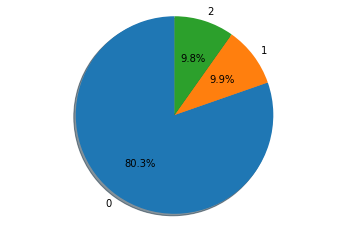

In [46]:
labels = all_data.partition.unique()
sizes = all_data.partition.value_counts().unique()
explode = (0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

El dataset consta de 202599 imagenes JPEG de 218x178 de las cuales el 80.3% son imagenes para entrenamiento y por otra parte, el 9.9% y 9.8% restantes son imagenes para test y validacion respectivamente.

A continuacion separaremos los datos de train, test y validation en sus respectivos dataframes y eliminaremos la columna "partition", ya que luego de esto no nos servira para nada mas

In [47]:
train = all_data[all_data['partition'] == 0].copy()
test = all_data[all_data['partition'] == 1].copy()
validation = all_data[all_data['partition'] == 2].copy()

In [48]:
train.drop(columns='partition', inplace=True)
test.drop(columns = 'partition', inplace=True)
validation.drop(columns = 'partition', inplace=True)

Si observamos la distribucion de la variable target, podemos apreciar que la variable target se encuentra balanceada, lo cual nos permite utilizar accuracy como metrica para la evaluacion de los modelos.

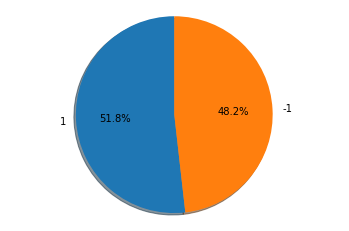

In [49]:
labels = all_data.Smiling.unique()
sizes = all_data.Smiling.value_counts().unique()
explode = (0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [50]:
all_data.Smiling.value_counts()

-1    104930
1      97669
Name: Smiling, dtype: int64

Para finalizar el analisis veremos algunos ejemplos de imagenes con su correspondiente variable Smiling, y eliminaremos el dataset all_data ya que no nos sera mas de utilidad y necesitaremos ahorrar recursos :).

No smiling


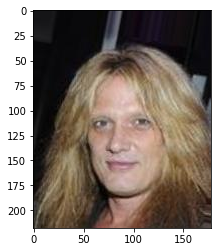

No smiling


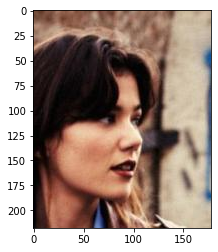

Smiling


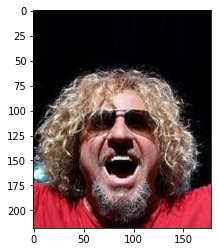

In [51]:
show_images(all_data.sample(3))

In [52]:
del all_data

## Entrenamiento

### Definiendo funciones y generadores de datos

Debido al tiempo que conlleva entrenar cada uno de los modelos, hemos optado por guardarlos en archivos binarios una vez finalizado el entrenamiento. De esta manera podemos hacer distintas pruebas con los modelos sin necesitar entrenarlos cada vez que abrimos el notebook.

A su vez, para reducir el tamaño de los modelos optamos por redimensionar el tamaño de las imagenes a 70x70, de esta manera la cantidad de entradas que tienen las neuronas de la primer capa se reduce de 116412 (178x218x3) a 14700 (70x70x3). Esto impactara a su vez en el tiempo de entrenamiento que necesitara cada modelo para converger a un valor aceptable.

In [53]:
import pickle

def get_pikle(file_name=''):
    filename = file_name
    infile = open(filename,'rb')
    new_nn = pickle.load(infile)
    infile.close()
    return new_nn
    
def save_pikle(file_name='', archive=None):
    filename = file_name
    outfile = open(filename,'wb')
    pickle.dump(archive,outfile)
    outfile.close()

Esta funcion añade las predicciones a los datasets para luego obtener las metricas del modelo.

In [54]:
def add_predictions(dataset, model):
    """
    Agregamos una columna 'prediction' con el label de la persona predicha.
    Otra columna 'prediction_confidence' con el valor que la red devolvió 
    para esa persona.
    Y una última columna 'correct', que determina si la predicción fue o no
    correcta.
    """
    
    data_gen = ImageDataGenerator(rescale=1. / 255)
    
    generator = data_gen.flow_from_dataframe(
    dataframe=dataset,
    directory=validation_data_dir,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    shuffle=False,
    target_size=(img_width, img_height))
    
    predictions = model.predict(generator)
    
    #predictions = model.predict(get_images_to_test(dataset))
    
    dataset['prediction'] = predictions.round().astype('int')
    dataset.loc[dataset.prediction == 0, 'prediction'] = -1
    
    dataset['prediction_confidence'] = predictions
    dataset['correct'] = dataset.prediction.astype('str') == dataset.Smiling

In [55]:
def get_images_to_test(df):
    images_to_test = []
    for index, sample in df.iterrows():
        image = img.load_img(FOLDER_IMAGES + sample.image_id,target_size=(img_height, img_width))    
        input_arr = np.array(img.img_to_array(image))
        images_to_test.append(input_arr)
    return [images_to_test]
    


Esta funcion recibe, por un lado, una lista de tuplas donde cada tupla contiene el nombre del dataset y el dataset como tal, y por otro lado un modelo, el cual sera utilizado para predecir los valores de los datasets y calcular sus matrices de confusion 

In [56]:
def get_confusion_matrix(datasets, model):
    
    for set_name, set_data in datasets:
        add_predictions(set_data, model)

        print('#' * 25, set_name, '#' * 25)
        print('accuracy', accuracy_score(set_data.Smiling.astype('int'), set_data.prediction))

        # plot confussion matrix

        plt.figure(figsize=(3,4))

        plt.xticks([-1, 1], ['No smiling', 'Smiling'], rotation=45)
        plt.yticks([-1, 1], ['No smiling', 'Smiling'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(set_data.Smiling.astype('int'), set_data.prediction), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()
    

In [57]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image as img

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

In [58]:
# redimensionamos las imagenes
img_width, img_height = 70, 70

#Configuraciones generales
train_data_dir = FOLDER_IMAGES
validation_data_dir = train_data_dir
nb_train_samples = len(train)
nb_test_samples = len(test)
nb_validation_samples = len(validation)

epochs = 3
batch_size = 500

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Para el generador de imagenes de train optamos por utilizar distintos parametros que ayuden a la red a evitar el sobreentrenamiento.

* rescale: No tiene efectos sobre el overfitting. Sirve para normalizar los valores de entrada entre 0 y 1
* shear_range: realiza transformaciones de corte en las imagenes desplazando cada punto de la imagen en una direccion fija.
* zoom_range: realiza zoom al azar en las imagenes.
* horizontal_flip: realiza un flip orizontal random en las imagenes.

Para los generadores de test y validation solo utilizaremos rescale para normalizar los valores de las entradas

In [59]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

datagen = ImageDataGenerator(rescale=1. / 255)

In [60]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_data_dir,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    target_size=(img_width, img_height))

Found 162770 validated image filenames belonging to 2 classes.


In [61]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test,
    directory=validation_data_dir,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    shuffle=False,
    target_size=(img_width, img_height))

Found 19867 validated image filenames belonging to 2 classes.


In [62]:
validation_generator = datagen.flow_from_dataframe(
    dataframe=validation,
    directory=validation_data_dir,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    shuffle=False,
    target_size=(img_width, img_height))

Found 19962 validated image filenames belonging to 2 classes.


### Red neuronal densa

Para la creacion de la primer red neuronal, optamos por utilizar  5 capas con 32, 64, 64, 32 y 1 neuronas respectivamente. Cada una de las capas utilizara la funcion de activacion sigmoid, que devolvera valores normalizados entre 0 y 1. A su vez entre cada capa existe una capa intermedia de dropout, que cortan conecciones entre neuronas de manera aleatoria durante el entrenamiento para evitar el overfitting.

In [26]:
simple_nn_1 = Sequential()
simple_nn_1.add(Flatten(input_shape=(img_height,img_width,3)))
simple_nn_1.add(Dense(32, activation='sigmoid'))
simple_nn_1.add(Dense(64, activation='sigmoid'))
simple_nn_1.add(Dropout(0.2))
simple_nn_1.add(Dense(64, activation='sigmoid'))
simple_nn_1.add(Dropout(0.2))
simple_nn_1.add(Dense(32, activation='sigmoid'))
simple_nn_1.add(Dropout(0.2))
simple_nn_1.add(Dense(1, activation='sigmoid'))

simple_nn_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [27]:
simple_nn_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 14700)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                470432    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

Vemos que nuestra red neuronal converge tan solo en 3 epocas a un valor bastante aceptable, siendo este del 82% en test y validation.

In [28]:
history = simple_nn_1.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_validation_samples)

Epoch 1/3
325/325 [==============================] - 3519s 11s/step - loss: 0.6981 - accuracy: 0.5073 - val_loss: 0.7039 - val_accuracy: 0.5167
Epoch 2/3
325/325 [==============================] - 3262s 10s/step - loss: 0.5838 - accuracy: 0.6836 - val_loss: 0.3781 - val_accuracy: 0.8000
Epoch 3/3
325/325 [==============================] - 3407s 10s/step - loss: 0.4565 - accuracy: 0.8021 - val_loss: 0.6335 - val_accuracy: 0.8271


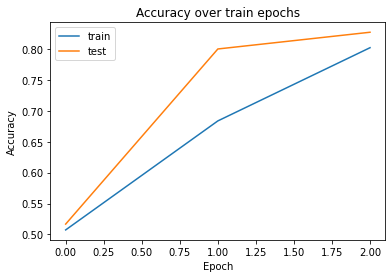

In [31]:
# plot accuracy over training epochs
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [32]:
loss, acc = simple_nn_1.evaluate(test_generator)
print('loss: ', loss)
print('Accuracy: ', acc)

621/621 [==============================] - 29s 47ms/step
loss:  0.40131622552871704
Accuracy:  0.8271002173423767


In [33]:
loss, acc = simple_nn_1.evaluate(validation_generator)
print('loss: ', loss)
print('Accuracy: ', acc)

624/624 [==============================] - 49s 78ms/step
loss:  0.37816810607910156
Accuracy:  0.8226129412651062


Found 19867 validated image filenames belonging to 2 classes.
######################### test_min #########################
accuracy 0.8271002164393215


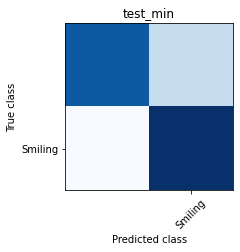

Found 19962 validated image filenames belonging to 2 classes.
######################### validation_min #########################
accuracy 0.8226129646328023


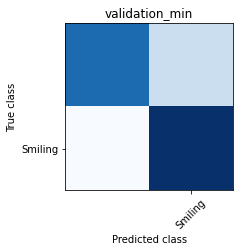

In [35]:
test_min = test.copy()
validation_min = validation.copy()
get_confusion_matrix([('test_min',test_min), ('validation_min',validation_min)], simple_nn_1)

In [39]:
good_predictions = test_min[test_min['correct'] == True].sample(4)
bad_predictions = test_min[test_min['correct'] == False].sample(4)

### Pedicciones correctas

No smiling
prediction: No smiling 0.1593836545944214


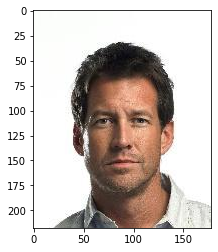

Smiling
prediction: Smiling 0.9079872369766235


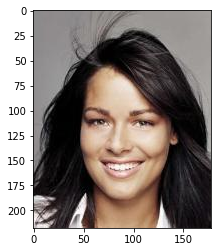

Smiling
prediction: Smiling 0.9077651500701904


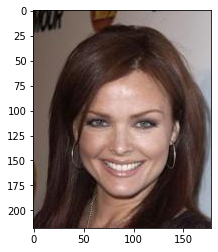

Smiling
prediction: Smiling 0.9001911878585815


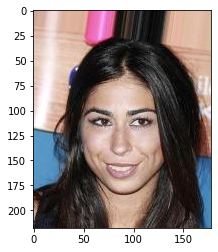

In [40]:
show_images(good_predictions, good_predictions.prediction_confidence.tolist())

### Predicciones incorrectas

No smiling
prediction: Smiling 0.7789539694786072


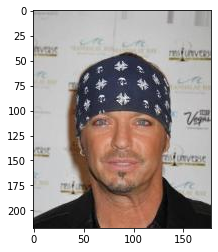

Smiling
prediction: No smiling 0.22414714097976685


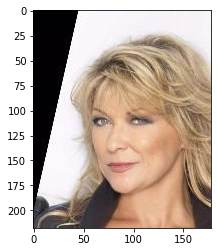

No smiling
prediction: Smiling 0.8322257995605469


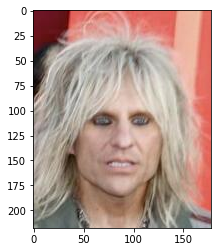

Smiling
prediction: No smiling 0.30344244837760925


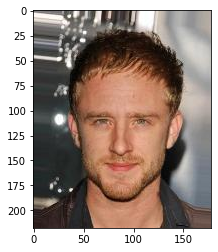

In [41]:
show_images(bad_predictions, bad_predictions.prediction_confidence.tolist())

Vemos que para las predicciones correctas el modelo nos arroja valores muy altos para las positivas (al rededor de 90%) y muy bajo para las negativas (alrededor del 15%).

Por otra parte para las predicciones incorrectas el modelo nos arroja valores un poco mas pequeños (entre 70% y 80%) para las positivas y un poco mas altas para las negativas (entre 20% y 30%).

### Red neuronal densa 2

Veremos si agregando neuronas conseguimos mejores metricas en nuestra red neuronal. Para ello esta vez crearemos una red muy parecida a la anterior, con la salvedad de que todas sus capas poseen 100 neuronas y la funcion de activacion de cada capa es relu.

In [64]:
simple_nn_2 = Sequential()

simple_nn_2.add(Flatten(input_shape=(img_height,img_width,3)))
simple_nn_2.add(Dense(100, activation='relu'))
simple_nn_2.add(Dropout(0.2))
simple_nn_2.add(Dense(100, activation='relu'))
simple_nn_2.add(Dropout(0.2))
simple_nn_2.add(Dense(100, activation='relu'))
simple_nn_2.add(Dropout(0.2))
simple_nn_2.add(Dense(100, activation='relu'))
simple_nn_2.add(Dropout(0.2))
simple_nn_2.add(Dense(1, activation='sigmoid'))

simple_nn_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [65]:
simple_nn_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 14700)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1470100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)              

In [31]:
history = simple_nn_2.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_test_samples)

Epoch 1/3
325/325 [==============================] - 3389s 10s/step - loss: 0.6303 - accuracy: 0.6450 - val_loss: 0.4656 - val_accuracy: 0.8378
Epoch 2/3
325/325 [==============================] - 3299s 10s/step - loss: 0.5434 - accuracy: 0.7364 - val_loss: 0.3903 - val_accuracy: 0.8441
Epoch 3/3
325/325 [==============================] - 3242s 10s/step - loss: 0.5263 - accuracy: 0.7487 - val_loss: 0.4628 - val_accuracy: 0.8468


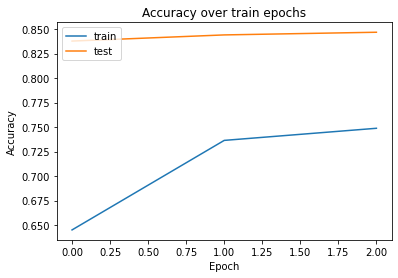

In [32]:
# plot accuracy over training epochs
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [33]:
loss, acc = simple_nn_2.evaluate(test_generator)
print('loss: ', loss)
print('Accuracy: ', acc)

621/621 [==============================] - 25s 40ms/step
loss:  0.4459618031978607
Accuracy:  0.8467810750007629


In [34]:
loss, acc = simple_nn_2.evaluate(validation_generator)
print('loss: ', loss)
print('Accuracy: ', acc)

624/624 [==============================] - 40s 64ms/step
loss:  0.3900143504142761
Accuracy:  0.8479110598564148


Found 19867 validated image filenames belonging to 2 classes.
######################### test_min #########################
accuracy 0.8467810942769417


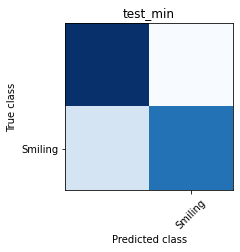

Found 19962 validated image filenames belonging to 2 classes.
######################### validation_min #########################
accuracy 0.8479110309588218


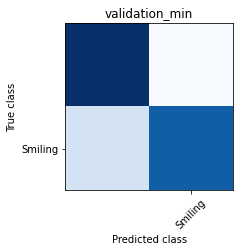

In [48]:
test_min = test.copy()
validation_min = validation.copy()
get_confusion_matrix([('test_min',test_min), ('validation_min',validation_min)], simple_nn_2)

Vemos que con esta configuracion pudimos incrementar en un 2% el desempeño de la red neuronal tanto en test y validation. Consideramos que no vale la pena ya que la diferencia en cuanto a parametros de entrenamiento es demasiado grande en comparacion con su mejoria en accuracy.

In [57]:
good_predictions = test_min[test_min['correct'] == True].sample(4)
bad_predictions = test_min[test_min['correct'] == False].sample(4)

### Predicciones correctas

Smiling
prediction: Smiling 0.6926965117454529


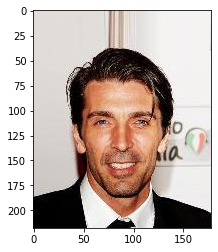

No smiling
prediction: No smiling 0.4305581748485565


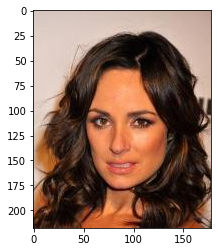

Smiling
prediction: Smiling 0.6819419860839844


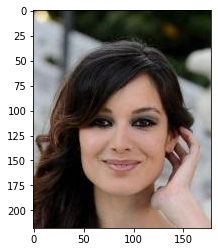

No smiling
prediction: No smiling 0.29147857427597046


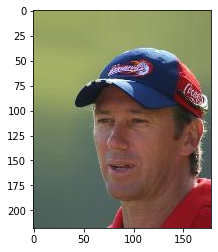

In [58]:
show_images(good_predictions, good_predictions.prediction_confidence.tolist())

### Predicciones incorrectas

Smiling
prediction: No smiling 0.3726038634777069


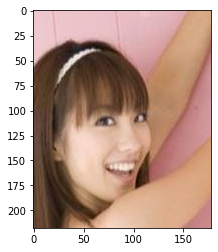

Smiling
prediction: No smiling 0.4986761212348938


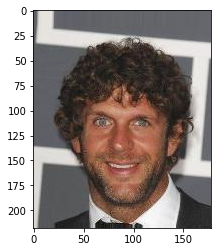

No smiling
prediction: Smiling 0.701928436756134


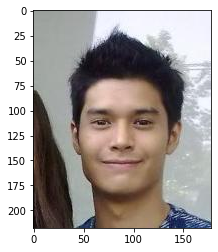

No smiling
prediction: Smiling 0.723107099533081


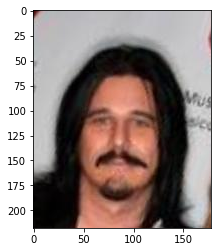

In [53]:
show_images(bad_predictions, bad_predictions.prediction_confidence.tolist())

### Red neuronal convolucional 1

La primer capa de la red consta de 32 filtros de 3x3 con una funcion de activacion Relu. A la salida de esta capa se aplica la operacion maxPooling de 2x2. Este proceso se repite igual para la segunda capa de convoluciones y la tercera, con la salvedad de que en esta ultima posee 64 filtros.

Por ultimo agregamos una capa densa de 64 neuronas con funcion de activacion Relu y una ultima capa de una sola neurona con funcion de activacion sigmoide para obtener las predicciones.

In [72]:
conv_nn_1 = Sequential()
conv_nn_1.add(Conv2D(32, (3, 3), input_shape=input_shape))
conv_nn_1.add(Activation('relu'))
conv_nn_1.add(MaxPooling2D(pool_size=(2, 2)))

conv_nn_1.add(Conv2D(32, (3, 3)))
conv_nn_1.add(Activation('relu'))
conv_nn_1.add(MaxPooling2D(pool_size=(2, 2)))

conv_nn_1.add(Conv2D(64, (3, 3)))
conv_nn_1.add(Activation('relu'))
conv_nn_1.add(MaxPooling2D(pool_size=(2, 2)))

conv_nn_1.add(Flatten())
conv_nn_1.add(Dense(64))
conv_nn_1.add(Activation('relu'))
conv_nn_1.add(Dropout(0.5))

conv_nn_1.add(Dense(1))
conv_nn_1.add(Activation('sigmoid'))

conv_nn_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [73]:
history = conv_nn_1.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_test_samples)

Epoch 1/3
325/325 [==============================] - 1296s 4s/step - loss: 0.6093 - accuracy: 0.6506 - val_loss: 0.3305 - val_accuracy: 0.8453
Epoch 2/3
325/325 [==============================] - 1212s 4s/step - loss: 0.3576 - accuracy: 0.8496 - val_loss: 0.4247 - val_accuracy: 0.8863
Epoch 3/3
325/325 [==============================] - 1220s 4s/step - loss: 0.2907 - accuracy: 0.8845 - val_loss: 0.4732 - val_accuracy: 0.8961


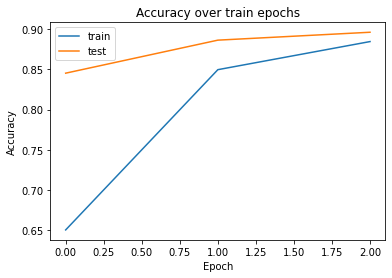

In [74]:
# plot accuracy over training epochs
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [81]:
loss, acc = conv_nn_1.evaluate(test_generator)  # returns loss and metrics
print('loss: ', loss)
print('Accuracy: ', acc)

621/621 [==============================] - 40s 65ms/step
loss:  0.2658969461917877
Accuracy:  0.8961091041564941


In [82]:
loss, acc = conv_nn_1.evaluate(validation_generator)  # returns loss and metrics
print('loss: ', loss)
print('Accuracy: ', acc)

624/624 [==============================] - 191s 305ms/step
loss:  0.17142494022846222
Accuracy:  0.8916942477226257


Como vemos la red convergio a un valor aceptable en tres epocas, alcanzando un accuracy de 88% y 89% en train y test respectivamente. Por otra parte en validation nos muestra un valor del 89%. Intuimos que de haber asignado un numero mayor de epocas al entrenamiento de la red no hubiera cambiado demasiado los resultados, debido a que, segun lo que nos muestra el grafico, el modelo ya estaba empezando a estabilizarse.

Found 19867 validated image filenames belonging to 2 classes.
######################### test_min #########################
accuracy 0.898323853626617


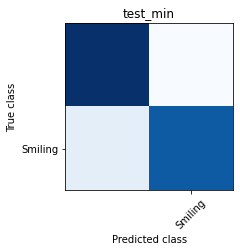

Found 19962 validated image filenames belonging to 2 classes.
######################### validation_min #########################
accuracy 0.8944494539625288


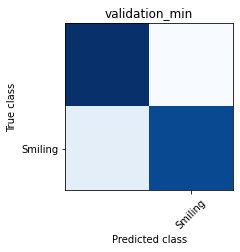

In [53]:
test_min = test.copy()
validation_min = validation.copy()
get_confusion_matrix([('test_min',test_min), ('validation_min',validation_min)], conv_nn_1)

In [55]:
good_predictions = test_min[test_min['correct'] == True].sample(3)
bad_predictions = test_min[test_min['correct'] == False].sample(3)

### Predicciones correctas

No smiling
prediction: No smiling 0.15749795734882355


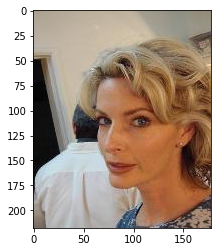

Smiling
prediction: Smiling 0.9915618300437927


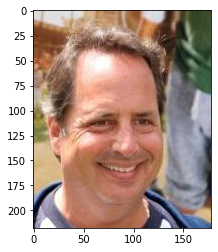

No smiling
prediction: No smiling 0.15957754850387573


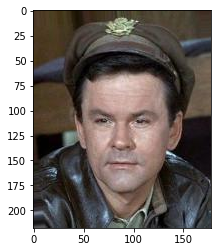

In [56]:
show_images(good_predictions, good_predictions.prediction_confidence.tolist())

### Predicciones incorrectas

Smiling
prediction: No smiling 0.37392163276672363


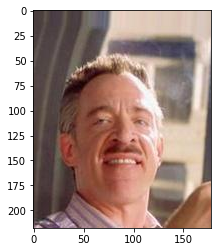

No smiling
prediction: Smiling 0.5902259349822998


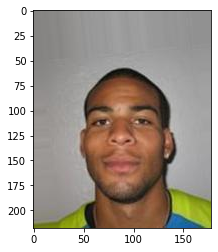

No smiling
prediction: Smiling 0.5158919095993042


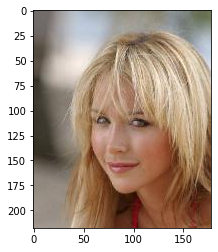

In [57]:
show_images(bad_predictions, bad_predictions.prediction_confidence.tolist())

Para el caso de esta red tambien se cumple, al igual que en la demas, que para las predicciones correctas nos arroja probabilidades muy altas o muy bajas (segun sea el caso), y para la incorrectas, predicciones mas "intermedias". Lo curioso es que en el caso de las predicciones correctas, la red convolucional llega a valores del 99% o 0.1%, demostrando estar "mucho mas segura" al dar sus predicciones, no asi como las redes neuronales densas solo alcanzaban valores del 90%, por ejemplo para el caso de una prediccion correcta y positiva.

### Red neuronal convolucional 2

Por ultimo crearemos una red convolucional muy similar a la anterior con la salvedad de que agregamos una segunda capa densa para ver si podemos incrementar su accuracy. A su vez, para esta red agregamos una epoca mas de entrenamiento con el mismo objetivo. 

In [50]:
conv_nn_2 = Sequential()
conv_nn_2.add(Conv2D(32, (3, 3), input_shape=input_shape))
conv_nn_2.add(Activation('relu'))
conv_nn_2.add(MaxPooling2D(pool_size=(2, 2)))

conv_nn_2.add(Conv2D(32, (3, 3)))
conv_nn_2.add(Activation('relu'))
conv_nn_2.add(MaxPooling2D(pool_size=(2, 2)))

conv_nn_2.add(Conv2D(64, (3, 3)))
conv_nn_2.add(Activation('relu'))
conv_nn_2.add(MaxPooling2D(pool_size=(2, 2)))

conv_nn_2.add(Flatten())
conv_nn_2.add(Dense(100))
conv_nn_2.add(Activation('relu'))
conv_nn_2.add(Dropout(0.5))

conv_nn_2.add(Dense(100))
conv_nn_2.add(Activation('relu'))
conv_nn_2.add(Dropout(0.5))

conv_nn_2.add(Dense(1))
conv_nn_2.add(Activation('sigmoid'))

conv_nn_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [51]:
history = None
history = conv_nn_2.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=4,
    validation_data=test_generator,
    validation_steps=nb_test_samples)

Epoch 1/4
325/325 [==============================] - 3925s 12s/step - loss: 0.4162 - accuracy: 0.7970 - val_loss: 0.1226 - val_accuracy: 0.9015
Epoch 2/4
325/325 [==============================] - 3590s 11s/step - loss: 0.2537 - accuracy: 0.8963 - val_loss: 0.1610 - val_accuracy: 0.9116
Epoch 3/4
325/325 [==============================] - 3694s 11s/step - loss: 0.2357 - accuracy: 0.9023 - val_loss: 0.2591 - val_accuracy: 0.9174
Epoch 4/4
325/325 [==============================] - 3583s 11s/step - loss: 0.2264 - accuracy: 0.9071 - val_loss: 0.1768 - val_accuracy: 0.9165


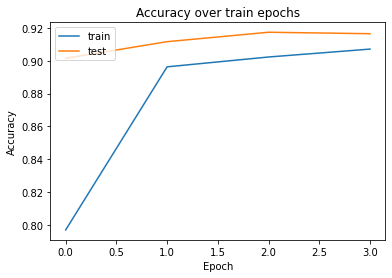

In [52]:
# plot accuracy over training epochs
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [54]:
loss, acc = conv_nn_2.evaluate(test_generator)  # returns loss and metrics
print('loss: ', loss)
print('Accuracy: ', acc)

621/621 [==============================] - 40s 64ms/step
loss:  0.4445054829120636
Accuracy:  0.9164443612098694


In [55]:
loss, acc = conv_nn_2.evaluate(validation_generator)  # returns loss and metrics
print('loss: ', loss)
print('Accuracy: ', acc)

624/624 [==============================] - 50s 81ms/step
loss:  0.2878098785877228
Accuracy:  0.9128844738006592


Found 19867 validated image filenames belonging to 2 classes.
######################### test_min #########################
accuracy 0.9164443549604873


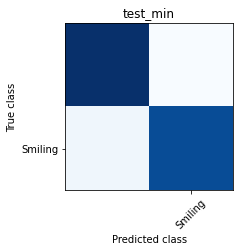

Found 19962 validated image filenames belonging to 2 classes.
######################### validation_min #########################
accuracy 0.9128844805129747


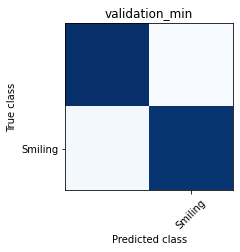

In [56]:
test_min = test.copy()
validation_min = validation.copy()
get_confusion_matrix([('test_min',test_min), ('validation_min',validation_min)], conv_nn_2)

In [59]:
good_predictions = test_min[test_min['correct'] == True].sample(4)
bad_predictions = test_min[test_min['correct'] == False].sample(4)

### Predicciones correctas

No smiling
prediction: No smiling 0.004687398672103882


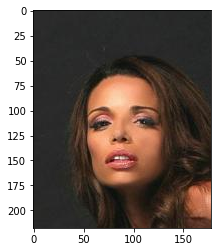

Smiling
prediction: Smiling 0.9933928847312927


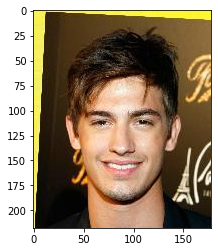

Smiling
prediction: Smiling 0.8939656615257263


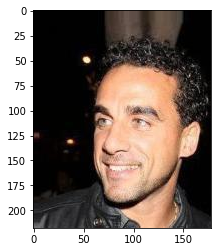

Smiling
prediction: Smiling 0.9964983463287354


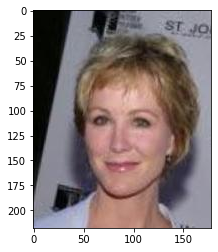

In [60]:
show_images(good_predictions, good_predictions.prediction_confidence.tolist())

### Predicciones incorrectas

Smiling
prediction: No smiling 0.0983424261212349


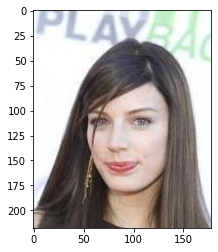

Smiling
prediction: No smiling 0.15376344323158264


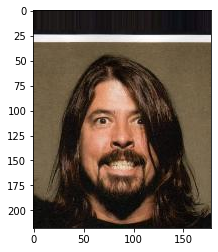

No smiling
prediction: Smiling 0.7708563804626465


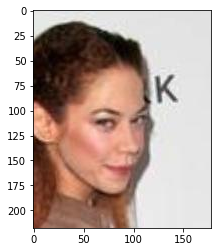

Smiling
prediction: No smiling 0.27182215452194214


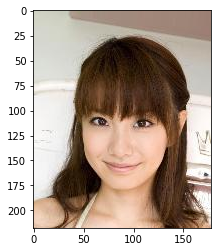

In [61]:
show_images(bad_predictions, bad_predictions.prediction_confidence.tolist())

Los resultados obtenidos para la anterior red convolucional tambien se ven reflejados en este modelo. Podemos observar que para los resultados correctos, en ocasiones nos arroja probabilidades del 0.004 para respuestas negativas, o 99% para respuestas positivas.

Para el caso de los errores notamos que, en ocasiones, realmente ni siquiera nosotros como humanos podemos decir con exactitud si la persona de la imagen esta sonriendo o no. En otras ocasiones tambien notamos que la etiqueta dice lo contrario a lo  que nosotros creemos que es a simple vista, y muchas veces nuestra opinion concuerda con la de la red, pero no con la etiqueta. Por ultimo existen ejemplos para los cuales la red se equivoca pero no podemos desarrollar una hipotesis sobre la razon

## Conclusiones

Como conclusion podemos mencionar que a conforme agregamos mas neuronas y capas a los dos tipos de redes notamos mejorias en su accuracy, lo cual puede indicarnos que el agregar mas neuronas y capas a los modelos podria ayudar a mejorar aun mas el desempeño de la red sin llegar al overfitting. 

Si bien creemos que los modelos llegaron a estabilizarse, agregar mas epocas a los entrenamientos podria ayudar a obtener un mejor desempeño, aunque no demasiado significativo, o en otras palabras, la curva de aprendizaje seguiria subiendo pero de una manera mas suave.

Los resultados arrojados por las redes neuronales convolucionales fueron mucho mas precisos que los de las redes neuronales densas, tanto en su nivel de accuracy como tambien en el grado de certidumbre de los modelos a la hora de dar una prediccion.

Consideramos que no era necesario seguir incrementando el desempeño de los modelos ya que, por un lado creemos haber logrado un grado de exactitud bastante aceptable, siendo el mas alto del 91% con la ultima red convolucional, y por otro lado a que no contamos con el hardware adecuado para que el proceso demore un tiempo razonable.

## Mejoras

Como mejoras consideramos que podriamos seguir entrenando cada modelo añadiendo mas ejemplos y epocas en los entrenamientos con el fin de aumentar el accuracy obtenido. Asi mismo podriamos intentar con otras funciones de activacion, o añadiendo mas neuronas y capas para ver si logramos alcanzar un valor cercano a 99%. Por ultimo tambien experimentariamos si agregar mas capas de convoluciones y maxpooling en las dos ultimas redes mejoraria aun mas el desempeño de la red.